In [3]:
import iapws
from iapws import IAPWS97 as gas

from typing import Optional, Tuple, List, Union

point_type = iapws.iapws97.IAPWS97


MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None


def check_is_valid_numerical(values: List[Union[None, float]]) -> None:
    """
    Проверить список, что все значения являются числами, если существуют
    :param List[Union[None, float]] values: Список из значений для проверки
    :return None:
    """
    for value in values:
        if value:
            if not isinstance(value, (int, float)):
                raise ValueError(f"Argument should be int or float value! Given {type(value)}")


def construct_cycle_points(
    p_0: Union[int, float],
    p_k: Union[int, float],
    t_0: Optional[Union[int, float]] = None,
    x_0: Optional[Union[int, float]] = None, 
) -> Tuple[point_type, point_type, point_type]:
    """
    Собрать точки процесса для расчета КПД
    Функция вернет точку начала процесса расширения в турбине, конца процесса расширения, а так же
    точку после питательного насоса.
    :param Union[int, float] p_0: Давление в MPa перед расширением в турбине
    :param Union[int, float] p_k: Давление в MPa после расширения в турбине
    :param Optional[Union[int, float]] t_0: Температура в K перед расширением в турбине
    :param Optional[Union[int, float]] x_0: Степень сухости пара перед расширением в турбине
    :return Tuple[point_type, point_type, point_type]:
    """
    
    check_is_valid_numerical([p_0, p_k, t_0, x_0])
    if not t_0 and not x_0:
        raise ValueError("Neither t_0 not x_0 is not provided for start expansion point!")
    if not (p_0 and p_k):
        raise ValueError("P_0 and p_k must be specified!")
    if x_0 and (x_0 > 1 or x_0 < 0):
        raise ValueError("x_0 should be between 0 and 1")
        
    if t_0:
        point_0 = gas(P=p_0, T=t_0)
    else:
        point_0 = gas(P=p_0, x=x_0)
    
    p_condenser = gas(P=p_k, s=point_0.s)
    p_pump = gas(P=p_k, x=0)
    return point_0, p_condenser, p_pump


def compute_cycle_efficiency(p_0: point_type, p_condenser: point_type, p_pump: point_type) -> float:
    """
    Вычисление термического КПД с упрощениями по точкам входа в турбину,
    выхода из нее и точке выхода питательной воды из насоса.
    :param iapws.iapws97.IAPWS97 point_0: Точка начала расширения пара / входа в турбину
    :param iapws.iapws97.IAPWS97 p_condenser: Точка завершения расширения пара / выхода из турбины
    :param iapws.iapws97.IAPWS97 p_pump: Точка относящаяся к воде после питательного насоса
    :return float: Термический КПД
    """
    useful_energy = p_0.h - p_condenser.h
    full_energy = p_0.h - p_pump.h
    efficiency = useful_energy / full_energy
    return efficiency


def solve_exercise(
    p_0: Union[int, float],
    p_k: Union[int, float],
    t_0: Optional[Union[int, float]] = None,
    x_0: Optional[Union[int, float]] = None,) -> float:
    """
    Решить все задачи с пары за пол секунды и найти КПД! =)
    :param Union[int, float] p_0: Давление в Pa перед расширением в турбине
    :param Union[int, float] p_k: Давление в Pa после расширения в турбине
    :param Optional[Union[int, float]] t_0: Температура в *C перед расширением в турбине
    :param Optional[Union[int, float]] x_0: Степень сухости пара перед расширением в турбине
    :return float: КПД цикла в долях
    """

    point_0, p_condenser, p_pump = construct_cycle_points(
        p_0=p_0 * unit,
        p_k=p_k * unit,
        t_0=to_kelvin(t_0),
        x_0=x_0
    )
    
    efficiency = compute_cycle_efficiency(p_0=point_0, p_condenser=p_condenser, p_pump=p_pump)
    
    return efficiency

In [36]:
# Начальные параметры:
p_0 = 5 * MPa
var_t_0 = np.arange(300, 600, 5)
var_p_k = np.arange(10, 50, 1)
var_p_k = list(map(lambda x: x * kPa, var_p_k))
var_p_k[:10]

efficiencies = []
t_0_list = []
p_k_list = []

for t_0 in var_t_0:
    for p_k in var_p_k:
        efficiency = solve_exercise(p_0=p_0, t_0=t_0, p_k=p_k)
        efficiencies.append(efficiency)
        t_0_list.append(t_0)
        p_k_list.append(p_k)

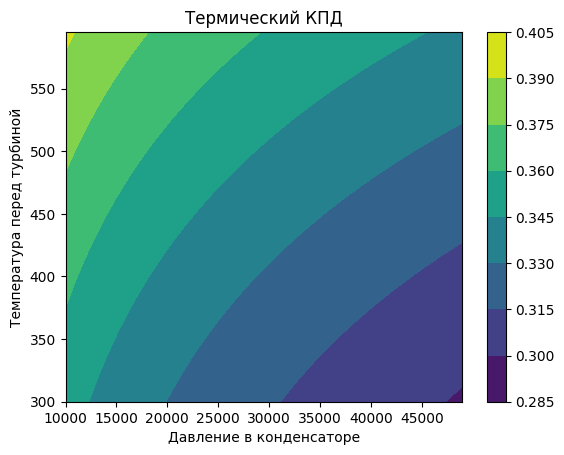

In [37]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(
    np.array(p_k_list).reshape(len(var_t_0), -1),
    np.array(t_0_list).reshape(len(var_t_0), -1),
    np.array(efficiencies).reshape(len(var_t_0), -1)
)
fig.colorbar(cp)
ax.set_title('Термический КПД')
ax.set_xlabel('Давление в конденсаторе')
ax.set_ylabel('Температура перед турбиной')
plt.show()